# Matérn Spectral Mixture (MSM) kernel 
## Gaussian process priors for pitch detection in polyphonic music
### Learning kernels in frequency domain
#### Written by Pablo A. Alvarado, Centre for Digital Music, Queen Mary University of London.


*Last updated Friday, 12 May 2017.*



The aim of this notebook is to ilustrate the approach proposed in (link) for pitch detection in polyphonic signals, applying Gaussian processes (GPs) models in Python using [GPflow](https://github.com/GPflow/GPflow). We first outline the mathematical formulation of the proposed model. Then we introduce how to learn hyperparameters in frequency domain. Finally we present an example for detecting two pitches in a polyphonic music signal.

The dataset used in this tutorial corresponds to the electric guitar mixture signal in http://winnie.kuis.kyoto-u.ac.jp/~yoshii/psdtf/. The first 4 seconds of the data were used for training, this segment corresponds to 2 isolated sound events, with pitch C4 and E4 respectively. The test data was made of three sound events with pitches C4, E4, C4+E4, i.e. the training data in addition to an event with both pitches. 

## GP additive model for pitch detection

Automatic music transcription aims to infer a symbolic representation, such as piano-roll or score, given an observed audio recording. From a Bayesian latent variable perspective, transcription consists in updating our beliefs about the symbolic description for a certain piece of music, after observing a corresponding audio recording. 

We approach the transcription problem from a time-domain source separation perspective. That is, given an audio recording $\mathcal{D}=\left\lbrace y_n, t_n \right\rbrace_{n=1}^{N}$, we seek to formulate a generative probabilistic model that describes how the observed polyphonic signal (mixture of sources) was generated and, moreover, that allows us to infer the latent variables associated with the piano-roll representation. To do so, we use the regression model 

\begin{align}
y_n = f(t_n) + \epsilon,
\end{align}
	
where $y_n$ is the value of the analysed polyphonic signal at time $t_n$, the noise follows a normal distribution $\epsilon \sim \mathcal{N}(0,\sigma^2)$, and the function $f(t)$ is a random process composed by a linear combination of $M$ sources $\left\lbrace  f_m(t) \right\rbrace _{m=1}^{M} $, that is

\begin{align}
f(t) = \sum_{m=1}^{M} f_{m}(t).
\end{align}
	
Each source is decomposed into the product of two factors, an amplitude-envelope or activation function $\phi_m(t)$, and a quasi-periodic or component function $w_{m}(t)$. The overall model is then 

\begin{align}
y(t) =  \sum_{m=1}^{M} \phi_{m}(t) w_{m}(t) + \epsilon.
\end{align}
		
We can interpret the set $\left\lbrace w_{m}(t)\right\rbrace_{m=1}^{M}$ as a dictionary  where each component $ w_{m}(t)$ is a quasi-periodic stochastic function with a defined pitch. Likewise, each stochastic function in $\left\lbrace \phi_{m}(t)\right\rbrace_{m=1}^{M}$ represents a row of the piano roll-matrix, i.e the time dependent non-negative activation of a specific pitch throughout the analysed piece of music.



Components $\left\lbrace w_{m}(t)\right\rbrace_{m=1}^{M}$ follow 

\begin{align}
w_m(t) \sim \mathcal{GP}(0,k_m(t,t')),
\end{align}


where the covariance $k_m(t,t')$ reflect the frequency content of the $m^{\text{th}}$ component, and has the form of a Matérn spectral mixture (MSM) kernel.

To guarantee the activations to be non-negative we apply non-linear transformations to GPs. To do so, we use the sigmoid function 
\begin{align}
\sigma(x) = \left[ 1 + \exp(-x) \right]^{-1},
\end{align}
Then, activations are defined as 
\begin{align*}
\phi_m(t) = \sigma( {g_{m}(t)} ),
\end{align*}

where $ \left\lbrace g_{m}(t)\right\rbrace_{m=1}^{M} $ are GPs. The sigmoid model  follows

\begin{align}
y(t)=
\sum_{m = 1}^{M}
\sigma( {g_{m}(t)} )
\
w_{m}(t) 
+ \epsilon.
\end{align}


## Learning hyperparameters in frequency domain

In this section we describe how to learn the hyperparameters for the components $\left\lbrace w_{m}(t)\right\rbrace_{m=1}^{M}$, and the activations  $\left\lbrace g_{m}(t)\right\rbrace_{m=1}^{M}$. 

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 3)
import numpy as np
import scipy as sp
import scipy.io as sio
import scipy.io.wavfile as wav
from scipy import signal 
import GPflow
import GPitch

In [ ]:
sf, y = wav.read('guitar.wav') #loading dataset
y = y.astype(np.float64)
yaudio = y / np.max(np.abs(y))
N = np.size(yaudio)
Xaudio = np.linspace(0, (N-1.)/sf, N)

X1, y1 = Xaudio[0:2*sf], yaudio[0:2*sf]        # define training data for component 1 and 2
X2, y2 = Xaudio[2*sf:4*sf], yaudio[2*sf:4*sf]

y1f, y2f = sp.fftpack.fft(y1), sp.fftpack.fft(y2) # get spectral density for each isolated sound event 
N1 = y1.size # Number of sample points
T = 1.0 / sf # sample period
F = np.linspace(0.0, 1.0/(2.0*T), N1/2)
S1 = 2.0/N1 * np.abs(y1f[0:N1/2])
S2 = 2.0/N1 * np.abs(y2f[0:N1/2])

([<matplotlib.lines.Line2D at 0x7f889b64d510>], (0, 5000))

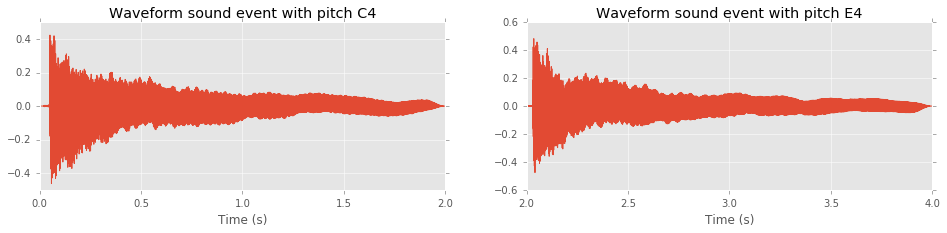

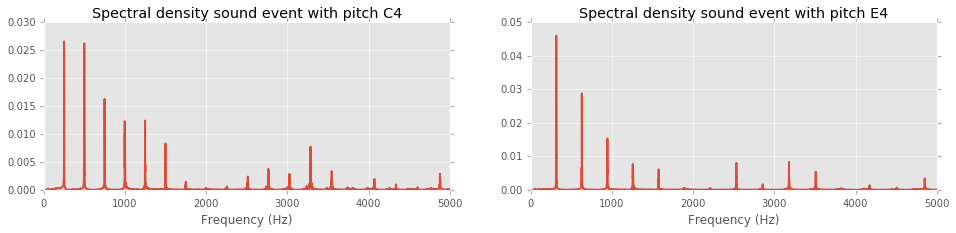

In [16]:
plt.figure()
plt.subplot(1,2,1), plt.title('Waveform sound event with pitch C4'), plt.xlabel('Time (s)'),
plt.plot(X1, y1),  

plt.subplot(1,2,2), plt.title('Waveform sound event with pitch E4'), plt.xlabel('Time (s)'),
plt.plot(X2, y2)

plt.figure()
plt.subplot(1,2,1), plt.title('Spectral density sound event with pitch C4'), plt.xlabel('Frequency (Hz)'),
plt.plot(F, S1, lw=2), plt.xlim([0, 5000])

plt.subplot(1,2,2), plt.title('Spectral density sound event with pitch E4'), plt.xlabel('Frequency (Hz)'),
plt.plot(F, S2, lw=2), plt.xlim([0, 5000])

### Learning frequency content of each component process $\left\lbrace w_{m}(t)\right\rbrace_{m=1}^{M}$


#### Example fitting one frequency component

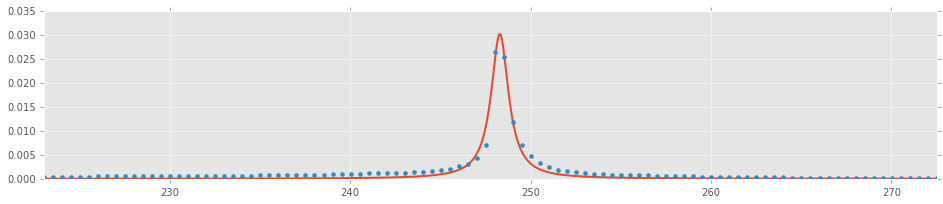

In [3]:
# example fitting one harmonic
idx = np.argmax(S1)
a, b = idx - 50, idx + 50
X, y = F[a: b,].reshape(-1,), S1[a: b,].reshape(-1,)
p0 = np.array([1., 1., 2*np.pi*F[idx]])
phat = sp.optimize.minimize(GPitch.Lloss, p0, method='L-BFGS-B', args=(X, y), tol = 1e-10, options={'disp': True})
pstar = phat.x
Xaux = np.linspace(X.min(), X.max(), 1000)
L = GPitch.Lorentzian(pstar,Xaux)
plt.figure(), plt.xlim([X.min(), X.max()])
plt.plot(Xaux, L, lw=2)
plt.plot(X, y, '.', ms=8)

In [4]:
Nh = 15 # maximun number of harmonics
s_1, l_1, f_1 = GPitch.learnparams(F, S1, Nh)
Nh1 = s_1.size
s_2, l_2, f_2 = GPitch.learnparams(F, S2, Nh)
Nh2 = s_2.size

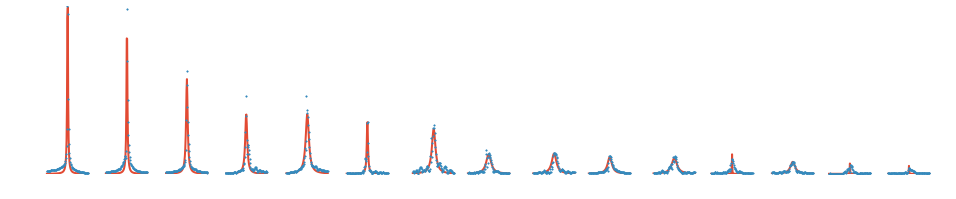

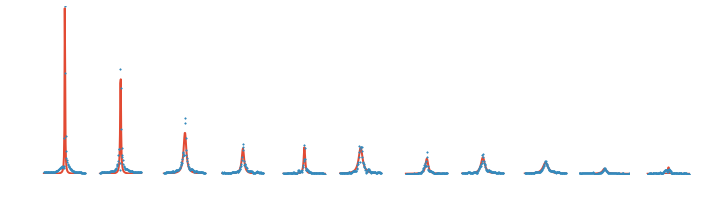

In [5]:
plt.figure()
for i in range(0, Nh1):
    idx = np.argmin(np.abs(F - f_1[i]))
    a = idx - 50
    b = idx + 50
    pstar = np.array([s_1[i], 1./l_1[i], 2.*np.pi*f_1[i]])
    learntfun = GPitch.Lorentzian(pstar, F)
    plt.subplot(1,Nh,i+1)
    plt.plot(F[a:b],learntfun[a:b],'', lw = 2)
    plt.plot(F[a:b],S1[a:b],'.', ms = 3)
    plt.axis('off')
    plt.ylim([S1.min(), S1.max()])
    
plt.figure()
for i in range(0, Nh2):
    idx = np.argmin(np.abs(F - f_2[i]))
    a = idx - 50
    b = idx + 50
    pstar = np.array([s_2[i], 1./l_2[i], 2.*np.pi*f_2[i]])
    learntfun = GPitch.Lorentzian(pstar, F)
    plt.subplot(1,Nh,i+1)
    plt.plot(F[a:b],learntfun[a:b],'', lw = 2)
    plt.plot(F[a:b],S2[a:b],'.', ms = 3)
    plt.axis('off')
    plt.ylim([S2.min(), S2.max()])

(<matplotlib.legend.Legend at 0x7f9ba28a1f50>,
 <matplotlib.text.Text at 0x7f9ba292c190>)

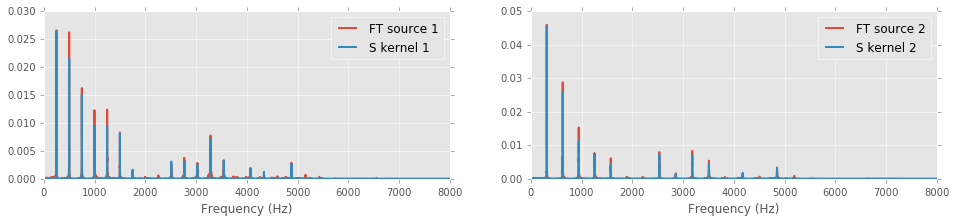

In [6]:
S1k = GPitch.LorM(F, s=s_1, l=1./l_1, f=2*np.pi*f_1)
S2k = GPitch.LorM(F, s=s_2, l=1./l_2, f=2*np.pi*f_2)

plt.figure(), plt.title('Approximate spectrum using Lorentzian mixture')
plt.subplot(1,2,1), plt.plot(F, S1, lw=2), plt.plot(F, S1k, lw=2)
plt.legend(['FT source 1', 'S kernel 1']), plt.xlabel('Frequency (Hz)')
plt.subplot(1,2,2), plt.plot(F, S2, lw=2), plt.plot(F, S2k, lw=2)
plt.legend(['FT source 2', 'S kernel 2']), plt.xlabel('Frequency (Hz)')

 /home/paad/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning:Casting complex values to real discards the imaginary part


(0, 0.03)

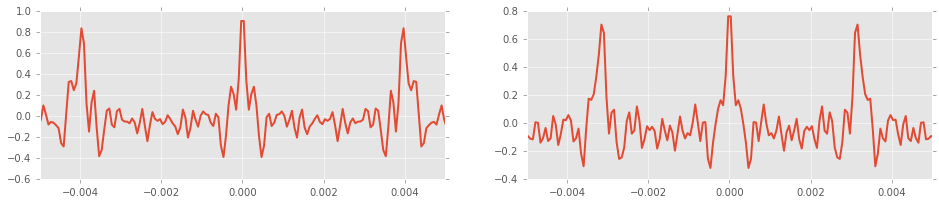

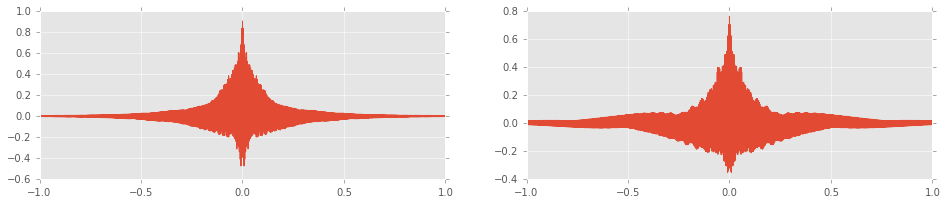

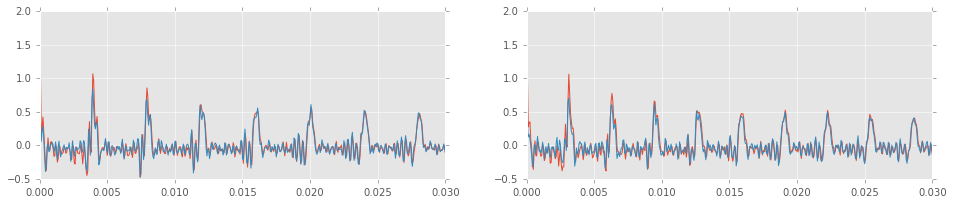

In [7]:
Xk = np.linspace(-1.,1.,2*16000).reshape(-1,1)
IFT_y1 = np.fft.ifft(np.abs(y1f))
IFT_y2 = np.fft.ifft(np.abs(y2f))
k1 = GPitch.MaternSM(Xk, s=s_1, l=1./l_1, f=2*np.pi*f_1)
k2 = GPitch.MaternSM(Xk, s=s_2, l=1./l_2, f=2*np.pi*f_2)

plt.figure()
plt.subplot(1,2,1), plt.plot(Xk, k1, lw=2), plt.xlim([-0.005, 0.005])
plt.subplot(1,2,2), plt.plot(Xk, k2, lw=2), plt.xlim([-0.005, 0.005])

plt.figure()
plt.subplot(1,2,1), plt.plot(Xk, k1)
plt.subplot(1,2,2), plt.plot(Xk, k2)

plt.figure(),
plt.subplot(1,2,1), plt.plot(X1[0:16000],IFT_y1[0:16000], lw=1), plt.plot(X1[0:16000],k1[16000:32000], lw=1)
plt.xlim([0, 0.03])
plt.subplot(1,2,2), plt.plot(X1[0:16000],IFT_y2[0:16000], lw=1), plt.plot(X1[0:16000],k2[16000:32000], lw=1)
plt.xlim([0, 0.03])

### Learning hyperparameters of activation processes $\left\lbrace \phi_{m}(t)\right\rbrace_{m=1}^{M}$

So far we have learnt the harmoninc content of the isolated events. Now we try to learn the parameters of the GP that describes the amplitude envelope. 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9ba38835d0>,
 [<matplotlib.lines.Line2D at 0x7f9ba0a77a10>])

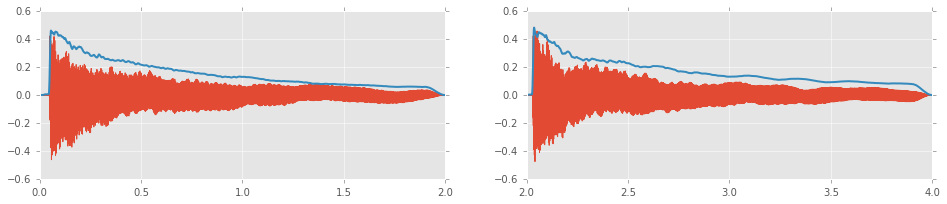

In [8]:
win = signal.hann(200)
env1 = signal.convolve(np.abs(y1), win, mode='same') / sum(win)
env1 = np.max(np.abs(y1))*(env1 / np.max(env1))
env1 = env1.reshape(-1,)
env2 = signal.convolve(np.abs(y2), win, mode='same') / sum(win)
env2 = np.max(np.abs(y2))*(env2 / np.max(env2))
env2 = env2.reshape(-1,)

plt.figure()
plt.subplot(1,2,1), plt.plot(X1, y1, ''), plt.plot(X1, env1, '', lw = 2)
plt.subplot(1,2,2), plt.plot(X2, y2, ''), plt.plot(X2, env2, '', lw = 2)

[ 0.38709571] [ 2.65419885] [ 1.57080461]


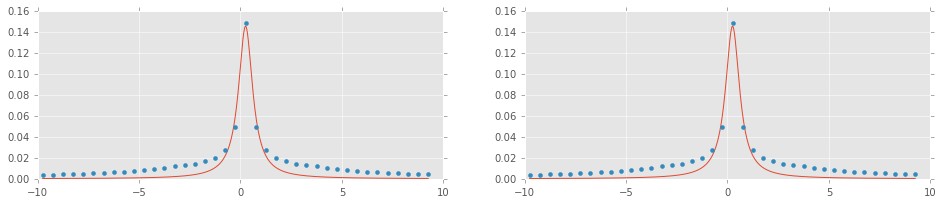

In [9]:
yf = fft(env1)
xf = np.linspace(-1.0/(2.0*T), 1.0/(2.0*T), N1)
S = 1.0/N1 * np.abs(yf)
sht = np.fft.fftshift(S)

a = np.argmin(np.abs(xf - (-10.)))
b = np.argmin(np.abs(xf - ( 10.)))
X, y = xf[a:b].reshape(-1,), sht[a:b].reshape(-1,)
p0 = np.array([1., 1., 0.])
phat = sp.optimize.minimize(GPitch.Lloss, p0, method='L-BFGS-B', args=(X, y), tol = 1e-10, options={'disp': True})
X2 = np.linspace(X.min(), X.max(), 1000)
L = GPitch.Lorentzian(phat.x, X2)
plt.figure()
plt.subplot(1,2,1), plt.plot(X2, L), plt.plot(X, y, '.', ms=8)
plt.subplot(1,2,2), plt.plot(X2, L), plt.plot(X, y, '.', ms=8)
s_env, l_env, f_env = np.hsplit(phat.x, 3)
print s_env, l_env, f_env

# Using the learnt MSM kernel for pitch detection

We keep the same form for the learnt variances $\sigma^{2}$, but we modify the lengthscale because we learnt the inverse, i.e. $l = \lambda^{-1}$. Also, we learnt the frequency vector in radians, that is why we convert it to Hz.

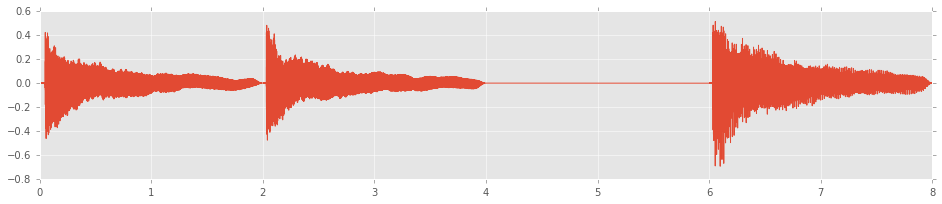

In [10]:
# To run the pitch detection change: RunExperiment = True
RunExperiment = False
if RunExperiment == True:
    GPitch.pitch('guitar.wav', windowsize=16000)
else:
    results = np.load('SIG_FL_results.npz')
    X = results['X']
    g1 = results['mu_g1']
    g2 = results['mu_g2']
    phi1 = GPitch.logistic(g1)
    phi2 = GPitch.logistic(g2)
    w1 = results['mu_f1']
    w2 = results['mu_f2']
    f1 = phi1*w1
    f2 = phi2*w2

Xtest1, ytest1 = Xaudio[0:4*sf], yaudio[0:4*sf]
Xtest2, ytest2 = Xaudio[6*sf:8*sf], yaudio[6*sf:8*sf]
Xtest = np.hstack((Xtest1, Xtest2)).reshape(-1,1)
ytest = np.hstack((ytest1, ytest2)).reshape(-1,1)
sf, sourceC = wav.read('source_C.wav')
sourceC = sourceC.astype(np.float64)
sourceC = sourceC / np.max(np.abs(sourceC))
sf, sourceE = wav.read('source_E.wav')
sourceE = sourceE.astype(np.float64)
sourceE = sourceE / np.max(np.abs(sourceE))

plt.figure()
plt.plot(Xtest, ytest)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9ba3566650>,
 [<matplotlib.lines.Line2D at 0x7f9ba2f3b250>])

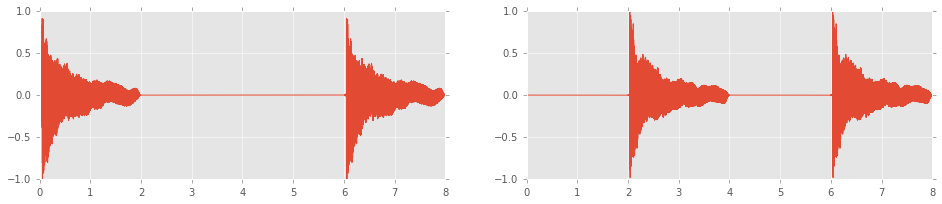

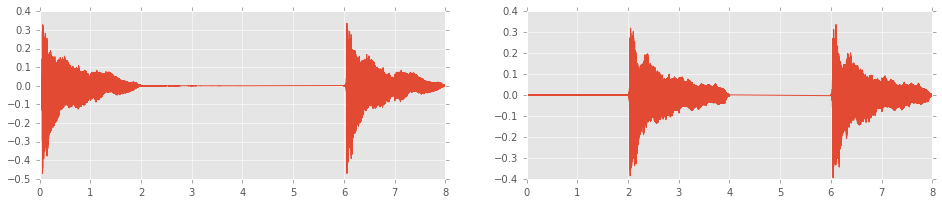

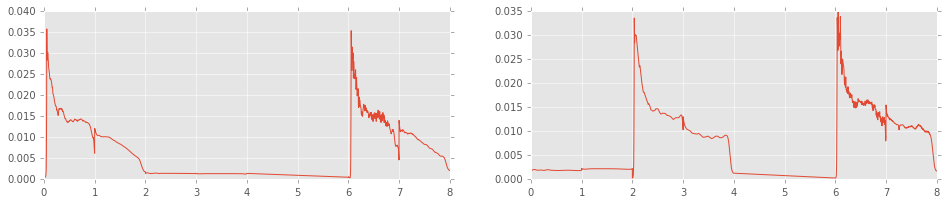

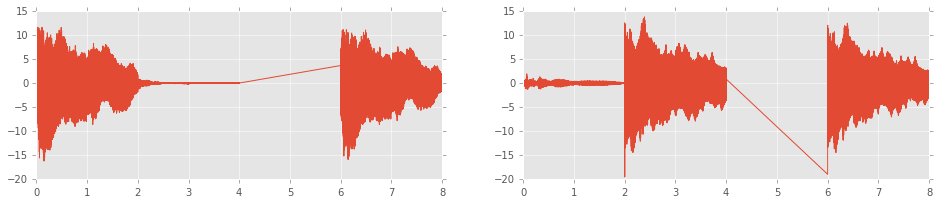

In [11]:
plt.figure()
plt.subplot(1,2,1), plt.plot(Xaudio, sourceC)
plt.xlim([X.min(), X.max()])
plt.subplot(1,2,2), plt.plot(Xaudio, sourceE)
plt.xlim([X.min(), X.max()])    
    
plt.figure()
plt.subplot(1,2,1), plt.plot(X, f1)
plt.subplot(1,2,2), plt.plot(X, f2)
    
plt.figure()
plt.subplot(1,2,1), plt.plot(X, phi1)
plt.subplot(1,2,2), plt.plot(X, phi2)

plt.figure()
plt.subplot(1,2,1), plt.plot(X, w1)
plt.subplot(1,2,2), plt.plot(X, w2)

## Piano-roll

In [40]:
#%% genetare piano-roll ground truth
jump = 100 #downsample
Xsubset = X[::jump]
oct1 = 24
oct2 = 84
Y = np.arange(oct1,oct2).reshape(-1,1)
Ns = Xsubset.size
Phi = np.zeros((Y.size, Ns))
#Phi[47-oct1, (Xsubset> 0.050 and  Xsubset< 1.973)] = 1.
C4_a1 = np.argmin(np.abs(Xsubset-0.050))
C4_b1 = np.argmin(np.abs(Xsubset-1.973))
C4_a2 = np.argmin(np.abs(Xsubset-6.050))
C4_b2 = np.argmin(np.abs(Xsubset-7.979))

Phi[47-oct1, C4_a1:C4_b1  ] = 1.
Phi[47-oct1, C4_a2:C4_b2  ] = 1.
Phi[47-oct1, C4_a3:C4_b3  ] = 1.
Phi[47-oct1, C4_a4:C4_b4  ] = 1.

E4_a1 = np.argmin(np.abs(Xsubset-2.050))
E4_b1 = np.argmin(np.abs(Xsubset-3.979))
E4_a2 = np.argmin(np.abs(Xsubset-6.050))
E4_b2 = np.argmin(np.abs(Xsubset-7.979))

Phi[51-oct1, E4_a1:E4_b1  ] = 1.
Phi[51-oct1, E4_a2:E4_b2  ] = 1.
Phi[51-oct1, E4_a3:E4_b3  ] = 1.
Phi[51-oct1, E4_a4:E4_b4  ] = 1.


Phi = np.abs(Phi-1)
[Xm, Ym] = np.meshgrid(Xsubset,Y)

#infered piano roll
Phi_i = np.zeros((Y.size, Ns))
Phi_i[47-oct1, :] = phi1[::jump].reshape(-1,)
Phi_i[51-oct1, :] = phi2[::jump].reshape(-1,)
Phi_i = np.abs(Phi_i-1)


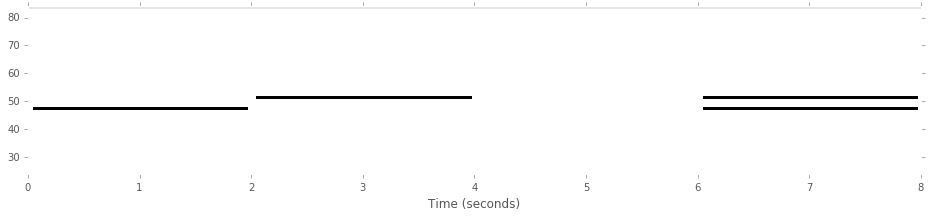

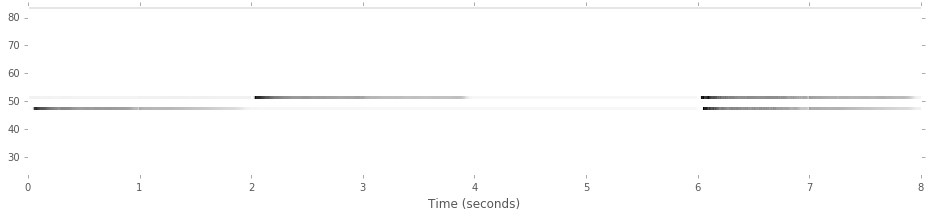

In [41]:
plt.figure()
plt.ylabel('')
plt.xlabel('Time (s)')
plt.pcolormesh(Xm, Ym, Phi, cmap='gray')
plt.ylim([oct1, oct2])
plt.xlim([0, 8])
plt.xlabel('Time (seconds)')

plt.figure()
plt.ylabel('')
plt.xlabel('Time (s)')
plt.pcolormesh(Xm, Ym, Phi_i, cmap='gray')
plt.ylim([oct1, oct2])
plt.xlim([0, 8])
plt.xlabel('Time (seconds)')